In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sentiment-labelled-sentences/sentiment labelled sentences/amazon_cells_labelled.txt
/kaggle/input/sentiment-labelled-sentences/sentiment labelled sentences/imdb_labelled.txt
/kaggle/input/sentiment-labelled-sentences/sentiment labelled sentences/readme.txt
/kaggle/input/sentiment-labelled-sentences/sentiment labelled sentences/yelp_labelled.txt


In [2]:
amazon = pd.read_csv('/kaggle/input/sentiment-labelled-sentences/sentiment labelled sentences/amazon_cells_labelled.txt', 
                     sep='\t',
                     lineterminator='\n',
                     names=['sentance', 'sentiment'] )
imdb = pd.read_csv('/kaggle/input/sentiment-labelled-sentences/sentiment labelled sentences/imdb_labelled.txt', 
                     sep='\t|\s{3}',
                     lineterminator='\n',
                     names=['sentance', 'sentiment'] )
yelp = pd.read_csv('/kaggle/input/sentiment-labelled-sentences/sentiment labelled sentences/yelp_labelled.txt', 
                     sep='\t',
                     lineterminator='\n',
                     names=['sentance', 'sentiment'] )
print(f"amazon = {amazon.shape}, imdb = {imdb.shape}, yelp = {yelp.shape}")

amazon = (1000, 2), imdb = (1000, 2), yelp = (1000, 2)


/tmp/ipykernel_24/3939053422.py:5: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  imdb = pd.read_csv('/kaggle/input/sentiment-labelled-sentences/sentiment labelled sentences/imdb_labelled.txt',


In [3]:
data = pd.DataFrame(data=np.concatenate([amazon,imdb,yelp], axis=0), columns=['sentance', 'sentiment'])
data.shape

(3000, 2)

In [4]:
data

,sentance,sentiment
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more...,0
4,The mic is great.,1
...,...,...
2995,I think food should have flavor and texture an...,0
2996,Appetite instantly gone.,0
2997,Overall I was not impressed and would not go b...,0
2998,"The whole experience was underwhelming, and I ...",0


In [5]:
data['sentance'] = data['sentance'].str.lower()
data

,sentance,sentiment
0,so there is no way for me to plug it in here i...,0
1,"good case, excellent value.",1
2,great for the jawbone.,1
3,tied to charger for conversations lasting more...,0
4,the mic is great.,1
...,...,...
2995,i think food should have flavor and texture an...,0
2996,appetite instantly gone.,0
2997,overall i was not impressed and would not go b...,0
2998,"the whole experience was underwhelming, and i ...",0


In [6]:
!pip install pyspellchecker
from spellchecker import SpellChecker
sc = SpellChecker()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 30.3 MB/s eta 0:00:00


In [7]:
import string

def remove_punc(sentance):
    return sentance.translate(str.maketrans('','',string.punctuation))

print(remove_punc('In this sentance, our job, my lord, is to remove all the punctuation!'))

In this sentance our job my lord is to remove all the punctuation


In [8]:
def correct(sentance):
    misspelled = sc.unknown(str(sentance).split())
    correct = [sc.correction(w) if w in misspelled else w for w in sentance.split()]
    return " ".join(filter(lambda c : c is not None, correct))

print(correct('its spellinf timr'))

its spelling time


In [9]:
from nltk.corpus import stopwords

def remove_stop(sentance):
    correct = [w for w in sentance.split() if w not in stopwords.words('english')]
    return " ".join(correct)

print(remove_stop('i know there is no longer stop, so why even bother'))

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


know longer stop, even bother


In [10]:
from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()

def stemming(sentance):
    correct = [stemmer.stem(w) for w in sentance.split()]
    return " ".join(correct)

print(stemming('And now it is time to finally stem this hell of a sentance, am I right, fellas?'))

and now it is time to final stem thi hell of a sentance, am I right, fellas?


In [11]:
def remove_numbers(sentance):
    return " ".join([s for s in sentance.split() if not s.isdigit()])

In [12]:
def prepare_data(sentance, vectorizer=None):
    sentance = remove_punc(sentance)
    sentance = correct(sentance)
    sentance = remove_stop(sentance)
    sentance = stemming(sentance)
    sentance = remove_numbers(sentance)
    if vectorizer is None:
        return sentance
    else: 
        return np.asarray(vectorizer(sentance).numpy(), dtype='float32').reshape(1,-1)

In [13]:
x = data['sentance']
y = data['sentiment']
x

0       so there is no way for me to plug it in here i...
1                             good case, excellent value.
2                                  great for the jawbone.
3       tied to charger for conversations lasting more...
4                                       the mic is great.
                              ...                        
2995    i think food should have flavor and texture an...
2996                             appetite instantly gone.
2997    overall i was not impressed and would not go b...
2998    the whole experience was underwhelming, and i ...
2999    then, as if i hadn't wasted enough of my life ...
Name: sentance, Length: 3000, dtype: object

In [14]:
x = x.map(lambda x : remove_punc(x))


In [15]:
x = x.map(lambda x : correct(x))
x

0       so there is no way for me to plug it in here i...
1                               good case excellent value
2                                   great for the jawbone
3       tied to charger for conversations lasting more...
4                                        the mic is great
                              ...                        
2995    i think food should have flavor and texture an...
2996                              appetite instantly gone
2997    overall i was not impressed and would not go back
2998    the whole experience was underwhelming and i t...
2999    then as if i hadnt wasted enough of my life th...
Name: sentance, Length: 3000, dtype: object

In [16]:
x = x.map(lambda x : remove_stop(x))
x

0                         way plug us unless go converter
1                               good case excellent value
2                                           great jawbone
3          tied charger conversations lasting 45 problems
4                                               mic great
                              ...                        
2995                    think food flavor texture lacking
2996                              appetite instantly gone
2997                      overall impressed would go back
2998    whole experience underwhelming think well go n...
2999    hadnt wasted enough life poured salt wound dra...
Name: sentance, Length: 3000, dtype: object

In [17]:
x = x.map(lambda x : stemming(x))
x

0                           way plug us unless go convert
1                                    good case excel valu
2                                            great jawbon
3                     tie charger convers last 45 problem
4                                               mic great
                              ...                        
2995                        think food flavor textur lack
2996                               appetit instantli gone
2997                         overal impress would go back
2998    whole experi underwhelm think well go ninja su...
2999    hadnt wast enough life pour salt wound draw ti...
Name: sentance, Length: 3000, dtype: object

In [18]:
x = x.map(lambda x : remove_numbers(x))
x

0                           way plug us unless go convert
1                                    good case excel valu
2                                            great jawbon
3                        tie charger convers last problem
4                                               mic great
                              ...                        
2995                        think food flavor textur lack
2996                               appetit instantli gone
2997                         overal impress would go back
2998    whole experi underwhelm think well go ninja su...
2999    hadnt wast enough life pour salt wound draw ti...
Name: sentance, Length: 3000, dtype: object

In [19]:
from keras.layers import TextVectorization
import tensorflow as tf
data_to_adapt = tf.constant(x)

n = 7
vectorizer = TextVectorization(output_mode='tf-idf', ngrams=n)
vectorizer.adapt(data_to_adapt)

In [20]:
vectorizer(x[0]).numpy()

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

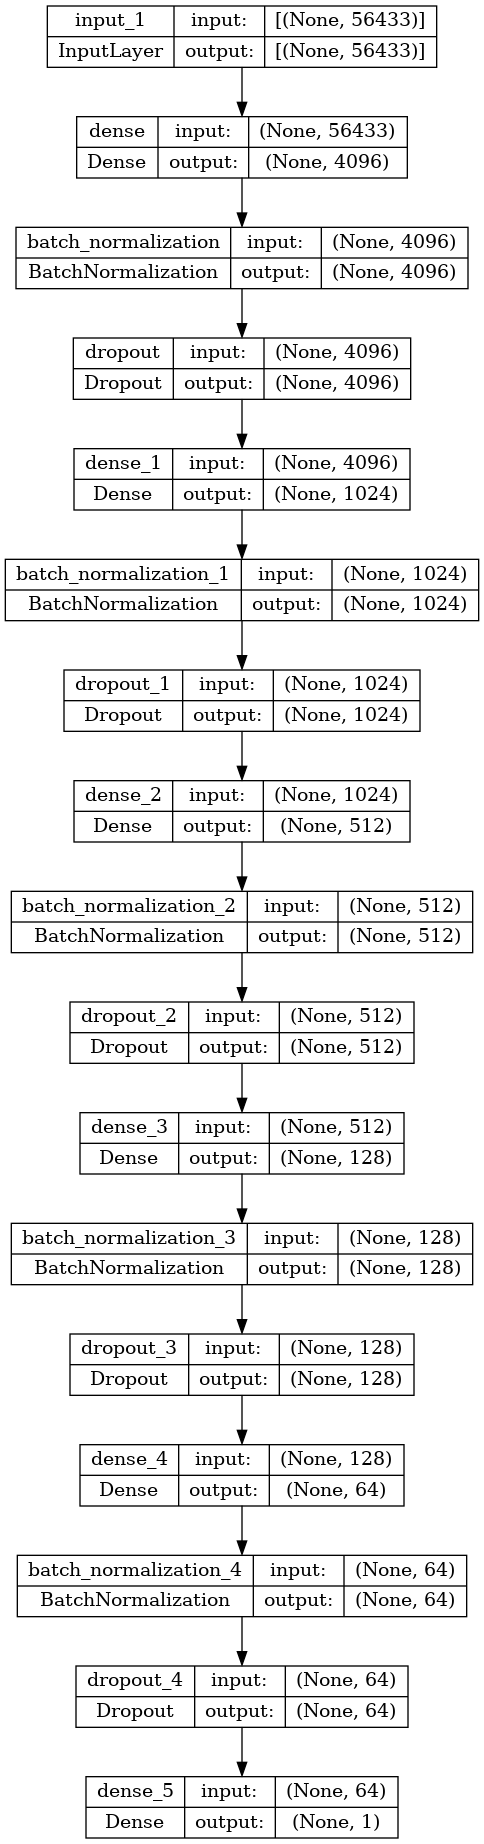

In [21]:
from keras.layers import Input, Dropout, Dense, Activation, BatchNormalization
from keras import Model
from keras.utils import plot_model

latent = [4096, 1024, 512, 128, 64]

inputs = Input(shape=(vectorizer.vocabulary_size(), ))
layer = inputs

for l in latent:
    layer = Dense(l, activation='relu')(layer)
    layer = BatchNormalization()(layer)
    layer = Dropout(0.4)(layer)

outputs = Dense(1, activation='sigmoid')(layer)

model = Model(inputs, outputs)
plot_model(model, show_shapes=True)

In [22]:
from sklearn.model_selection import train_test_split

x_data = x.map(lambda x : vectorizer(x).numpy())

In [23]:
x_data = np.asarray([e.astype('float32') for e in x_data])

In [24]:
y_data = np.asarray(y, dtype='float32')

In [25]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, stratify=y, random_state=1234)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=1234)

In [26]:
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping

callback = EarlyStopping(monitor='val_loss', patience=10)

model.compile(optimizer=Adam(learning_rate=0.01), loss='mse', metrics=['accuracy'])
model.fit(x=x_train, y=y_train, validation_data=[x_val, y_val], epochs=50, batch_size=64, callbacks=[callback])

Epoch 1/50
30/30 [==============================] - 6s 80ms/step - loss: 0.2538 - accuracy: 0.6365 - val_loss: 0.4595 - val_accuracy: 0.5271
Epoch 2/50
30/30 [==============================] - 2s 68ms/step - loss: 0.1314 - accuracy: 0.8266 - val_loss: 0.2209 - val_accuracy: 0.7542
Epoch 3/50
30/30 [==============================] - 2s 69ms/step - loss: 0.0605 - accuracy: 0.9182 - val_loss: 0.2363 - val_accuracy: 0.7417
Epoch 4/50
30/30 [==============================] - 2s 60ms/step - loss: 0.0362 - accuracy: 0.9531 - val_loss: 0.2575 - val_accuracy: 0.7063
Epoch 5/50
30/30 [==============================] - 2s 60ms/step - loss: 0.0300 - accuracy: 0.9594 - val_loss: 0.2407 - val_accuracy: 0.7188
Epoch 6/50
30/30 [==============================] - 2s 61ms/step - loss: 0.0290 - accuracy: 0.9630 - val_loss: 0.1796 - val_accuracy: 0.7646
Epoch 7/50
30/30 [==============================] - 2s 61ms/step - loss: 0.0213 - accuracy: 0.9724 - val_loss: 0.2266 - val_accuracy: 0.7417
Epoch 8/50
30

In [27]:
model.evaluate(x_test, y_test)

19/19 [==============================] - 0s 9ms/step - loss: 0.2010 - accuracy: 0.7333


[0.20104901492595673, 0.7333333492279053]

In [28]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(x_train, y_train)

KNeighborsClassifier()

In [29]:
knn.score(x_test, y_test)

0.6283333333333333

In [30]:
dict = {0 : 'negative', 1 : 'positive'}

In [31]:
dict.get(np.round(model.predict(prepare_data('Wow, such a great movie!', vectorizer))).item())

1/1 [==============================] - 0s 185ms/step


'positive'

In [32]:
model.save('/kaggle/working/sentiment_model.h5')